In [2]:
import re
from scapy.all import Raw
from scapy.all import rdpcap

# Load PCAP file
packets = rdpcap('Automotive_Ethernet_with_Attack_original_10_17_20_04_test.pcap')

In [3]:
import pandas as pd
import csv

# Load the CSV file without headers
labels_df = pd.read_csv('y_test.csv', header=None)
labels_df.columns = ['packet_id', 'target', 'label_of_protocol']  

In [4]:
len(labels_df["packet_id"])

791611

In [5]:
print(len(packets))

791611


In [6]:
processed_data = {
    (32, 32): {'Normal': [], 'Abnormal': []},
    (60, 60): {'Normal': [], 'Abnormal': []},
    (116, 116): {'Normal': [], 'Abnormal': []},
    (228, 228): {'Normal': [], 'Abnormal': []},
    (452, 452): {'Normal': [], 'Abnormal': []}
}

In [7]:
def convert_payload_to_hex(packet_load):
    # Convert the byte array to a hex string
    hex_string = packet_load.hex()
    # Pad the hex string with leading zeros to ensure consistent length
    padded_hex_string = hex_string.rjust(2 * len(packet_load), '0')
    # Convert individual hex characters to '\x' format
    formatted_hex_string = []
    for i in range(0, len(padded_hex_string), 2):
        formatted_hex_string.append(f"\\x{padded_hex_string[i]}{padded_hex_string[i + 1]}")

    # Combine formatted hex characters into a single string
    formatted_hex_string = "".join(formatted_hex_string)

    return formatted_hex_string

In [8]:
def hex_to_decimal(hex_string):
    hex_bytes = hex_string.split('\\x')[1:]  
    decimal_values = [int(byte, 16) for byte in hex_bytes]
    return decimal_values

In [9]:
def determine_target_group_size(packet_length):
    # Define the target packet lengths
    target_lengths = [32, 60, 116, 228, 452]

    # Specific conditions
    if packet_length > 452:
        return target_lengths[-1]
    elif 400 < packet_length <= 452:
        return 452
    elif 200 <= packet_length <= 400:
        return 228
    elif 75 <= packet_length < 200:
        return 116
    elif 40 < packet_length < 75:
        return 60
    elif 32 < packet_length <= 40:  
        return 32
    elif packet_length <= 32:
        return target_lengths[0]

In [10]:
def adjust_packet_size(packet, target_size):
    current_size = len(packet)

    if current_size < target_size:
        # Pad with zeros
        packet.extend([0] * (target_size - current_size))
    elif current_size > target_size:
        # Truncate the packet
        packet = packet[:target_size]

    return packet

In [11]:
def add_packet_to_processed_data(packet, label, processed_data):
    packet_size = len(packet)
    target_key = (packet_size, packet_size)

    # Ensure the target_key is initialized as a dictionary in processed_data
    if target_key not in processed_data:
        processed_data[target_key] = {'Normal': [], 'Abnormal': []}

    # Check if the label is either "Normal" or "Abnormal" and add to the corresponding list
    if label == 'Normal':
        processed_data[target_key]['Normal'].append(packet)
    elif label == 'Abnormal':
        processed_data[target_key]['Abnormal'].append(packet)
    else:
        # Handle unexpected labels, if needed
        print(f"Unexpected label '{label}' for packet. Not added to processed data.")


In [12]:
from tqdm import tqdm

packet_lengths = []
for idx, packet in tqdm(enumerate(packets), total=len(packets)):
    packet_load = packet[Raw].load if Raw in packet else b''
    corrected_hex_str = convert_payload_to_hex(packet_load)
    decimal_values = hex_to_decimal(corrected_hex_str)
    original_size = len(decimal_values)
    packet_lengths.append(original_size)
    target_size = determine_target_group_size(original_size)
    decimal_array = adjust_packet_size(decimal_values, target_size)
    # Retrieve the label for the current packet
    label = labels_df.at[idx, 'target']
    # Add the packet and label to processed data
    add_packet_to_processed_data(decimal_array, label, processed_data)

100%|██████████| 791611/791611 [01:14<00:00, 10618.52it/s]


In [13]:
# Assuming processed_data is already populated
for key, label_data in processed_data.items():
    print(f"Key: {key}")
    for label, packets in label_data.items():
        print(f"  Label '{label}' has {len(packets)} packets")

Key: (32, 32)
  Label 'Normal' has 471541 packets
  Label 'Abnormal' has 87859 packets
Key: (60, 60)
  Label 'Normal' has 5067 packets
  Label 'Abnormal' has 26013 packets
Key: (116, 116)
  Label 'Normal' has 3170 packets
  Label 'Abnormal' has 0 packets
Key: (228, 228)
  Label 'Normal' has 0 packets
  Label 'Abnormal' has 0 packets
Key: (452, 452)
  Label 'Normal' has 180999 packets
  Label 'Abnormal' has 16962 packets


In [14]:
import os
import numpy as np
import csv

def update_processed_data_with_nxn_groups_and_save_labels(processed_data, labels_folder_path):
    """
    Reshapes 'Normal' and 'Abnormal' data into NXN groups, merges them, and saves one label per group in a specified folder.
    """
    # Create the labels folder if it doesn't exist
    if not os.path.exists(labels_folder_path):
        os.makedirs(labels_folder_path)

    for key, labels in processed_data.items():
        N = key[0]  # N is the first element of the key tuple
        normal_packets = labels['Normal']
        abnormal_packets = labels['Abnormal']
        nxn_normal_packets = group_packets_into_nxn(normal_packets, N)
        nxn_abnormal_packets = group_packets_into_nxn(abnormal_packets, N)

        # Check if either group is empty and handle accordingly
        if nxn_normal_packets.size == 0:
            merged_packets = nxn_abnormal_packets
        elif nxn_abnormal_packets.size == 0:
            merged_packets = nxn_normal_packets
        else:
            merged_packets = np.concatenate((nxn_normal_packets, nxn_abnormal_packets), axis=0)

        packet_labels = ['Normal'] * len(nxn_normal_packets) + ['Abnormal'] * len(nxn_abnormal_packets)

        # Update the processed_data dictionary
        processed_data[key] = merged_packets

        # Save one label per NXN group to a CSV file inside the labels folder
        shape_str = f"{N}x{N}"
        current_labels_file_path = os.path.join(labels_folder_path, f"{shape_str}.csv")
        with open(current_labels_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Group Index', 'Label'])  # Header
            for index in range(len(packet_labels)):
                writer.writerow([index, packet_labels[index]])

def group_packets_into_nxn(packets, N):
    """
    Groups packets into NXN sets and pads with zero-packets if necessary.
    """
    if not packets:
        return np.array([])  # Return an empty array if packets list is empty

    nxn_packets = []
    for i in range(0, len(packets), N):
        group = packets[i:i + N]
        # Pad with zero-packets if the group is not full
        while len(group) < N:
            group.append([0] * N)  # Assuming zero-packets are represented as [0] * N
        nxn_packets.append(group)
    return np.array(nxn_packets)

# Example usage
update_processed_data_with_nxn_groups_and_save_labels(processed_data, 'test_labels')


In [15]:
# Check the result
for key, packets in processed_data.items():
    print(f"Size {key}: Number of packets = {len(packets)}")


Size (32, 32): Number of packets = 17482
Size (60, 60): Number of packets = 519
Size (116, 116): Number of packets = 28
Size (228, 228): Number of packets = 0
Size (452, 452): Number of packets = 439


In [17]:
import numpy as np
import os

def normalize_group(group):
    """
    Normalizes an entire group of packets.
    Assumes 'group' is a numpy array where each element is a packet.
    """
    # Convert the list of packets into a 2D numpy array
    group_array = np.array(group)

    # Normalize the entire array
    normalized_group = group_array / 255.0
    return normalized_group

def save_normalized_data(processed_data, save_folder):
    """
    Normalizes and saves NXN packet groups as numpy files in a specified folder.
    Each key (packet shape) will have one file containing all normalized groups.
    """
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)  # Create the folder if it doesn't exist

    for key, packet_groups in processed_data.items():
        all_normalized_groups = []

        for group in packet_groups:
            normalized_group = normalize_group(group)
            all_normalized_groups.append(normalized_group)

        # Combine all groups for the current key into one array
        combined_normalized_groups = np.array(all_normalized_groups)

        # Save the combined array to a file
        shape_str = f"{key[0]}x{key[0]}"
        file_path = os.path.join(save_folder, f"test_{shape_str}_normalized.npy")
        np.save(file_path, combined_normalized_groups)

# Example usage
save_normalized_data(processed_data, 'test_normalized_packet_data')

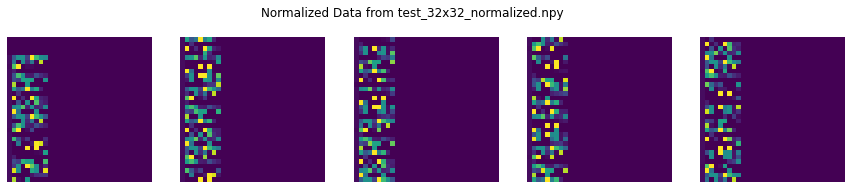

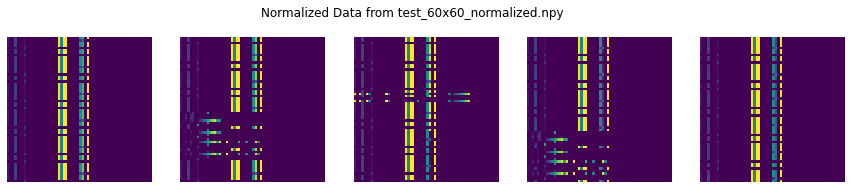

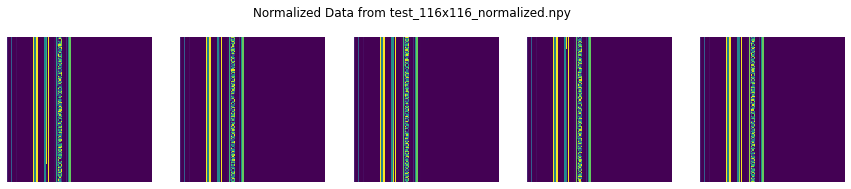

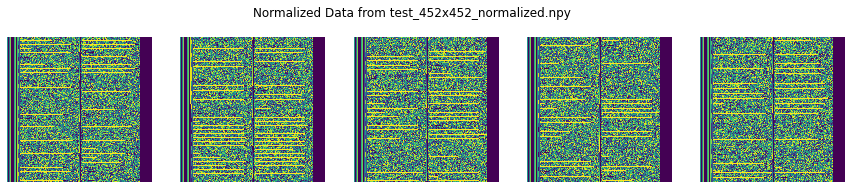

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_normalized_data(file_paths, num_samples=5):
    for file_path in file_paths:
        # Load normalized data
        data = np.load('test_normalized_packet_data/' + file_path)

        # Select samples to plot
        samples_to_plot = data[:num_samples]

        # Plot each sample
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i, sample in enumerate(samples_to_plot):
            axes[i].imshow(sample, cmap='viridis', interpolation='none')
            axes[i].axis('off')
        plt.suptitle(f'Normalized Data from {file_path}')
        plt.show()

# Example usage
file_paths = ['test_32x32_normalized.npy', 'test_60x60_normalized.npy', 'test_116x116_normalized.npy', 'test_452x452_normalized.npy']  
plot_normalized_data(file_paths)
